In [16]:
import sys
sys.path.append('../')
import pandas as pd
import backtrader as bt
from datetime import datetime
import matplotlib.pyplot as plt
from Tools.backtest_tools import *
import plotly.graph_objects as go
import pandas_ta as ta 
from Tools.plotting import CandlePlot

In [17]:
# Load the data and convert the timestamp to datetime
df = pd.read_csv('../DB/5m/ARBUSDT_5m.csv', parse_dates=True) 

# df['datetime'] = pd.to_datetime(df['datetime'], unit='ms')
# # # Convert 'date' to datetime format
df['datetime'] = pd.to_datetime(df['datetime'])  # Assuming the 'date' is in milliseconds

# # # Set 'date' as index
df.set_index('datetime', inplace=True)

# df.iloc[0]
# df.dtypes
# df.head()
df_t = df[:].copy()

In [18]:
class BBands:
    def __init__(
            self, 
            df, 
            type=['long', 'short'],
            slow_ema_w = 50,
            fast_ema_w = 30,
            rsi_w = 10,
            bb_w = 15,
            std_w=1.5,
            ATR_w=7

            ) -> None:
        
        self.df = df
        self.use_long = True if "long" in type else False
        self.use_short = True if "short" in type else False
        self.slow_ema_w = 50
        self.fast_ema_w = 30
        self.rsi_w = 10
        self.bb_w = 15
        self.std_w=1.5
        self.ATR_w=7

    def populate_indicators(self):
        # -- Clear dataset --
        df = self.df
        df.drop(columns=df.columns.difference(['open','high','low','close','volume']), inplace=True)

        df["open_long_market"] = False
        df["close_long_market"] = False
        df["open_short_market"] = False
        df["close_short_market"] = False

        
        # -- Populate indicators --
        df['slow_ema'] = ta.ema(self.df.close, length=self.slow_ema_w)
        df['fast_ema'] = ta.ema(self.df.close, length=self.fast_ema_w)
        df['rsi'] = ta.rsi(self.df.close, length=self.rsi_w)
        m_bbands = ta.bbands(self.df.close, length=self.bb_w, std=self.std_w) 
        df['ATR']= ta.atr(self.df.high, self.df.low, self.df.close, length=self.ATR_w)

        df = df.join(m_bbands)
        
        # df = get_n_columns(df, ["lvl_above",  "lvl_below", "close"], 1)
        
        self.df = df    
        return self.df

    def populate_buy_sell(self): 
        df = self.df
        # -- Initiate populate --
        if self.use_long:
            # -- Populate open long market --
            df.loc[
                (df['fast_ema'] > df['slow_ema']) 
                & (df['close'] < df['BBL_15_1.5'])                 
                , "open_long_market"
            ] = True
            
            
            # -- Populate close long market --
            df.loc[
                (df['close'] > df['BBU_15_1.5']) 
                , f"close_long_market"
            ] = True

        if self.use_short:
            # -- Populate open short market --
            df.loc[
                (df['fast_ema'] < df['slow_ema']) 
                & (df['close'] > df['BBU_15_1.5'])                 
                , "open_short_market"
            ] = True
            
            # -- Populate close short market --
            df.loc[
                (df['close'] < df['BBL_15_1.5']) 
                , f"close_short_market"
            ] = True
               
        self.df = df   
        return self.df
    

    # Running the backtest
    
    def run_backtest(self, initial_wallet=1000, leverage=1):
        df = self.df[:]
        wallet = initial_wallet
        maker_fee = 0.0002
        taker_fee = 0.0007
        trades = []
        days = []
        current_day = 0
        previous_day = 0
        current_position = None

        for index, row in df.iterrows():
            
            # -- Add daily report --
            current_day = index.day
            if previous_day != current_day:
                temp_wallet = wallet
                if current_position:
                    if current_position['side'] == "LONG":
                        close_price = row['close']
                        trade_result = (close_price - current_position['price']) / current_position['price']
                        temp_wallet += temp_wallet * trade_result
                        fee = temp_wallet * taker_fee
                        temp_wallet -= fee
                    elif current_position['side'] == "SHORT":
                        close_price = row['close']
                        trade_result = (current_position['price'] - close_price) / current_position['price']
                        temp_wallet += temp_wallet * trade_result
                        fee = temp_wallet * taker_fee
                        temp_wallet -= fee
                    
                days.append({
                    "day":str(index.year)+"-"+str(index.month)+"-"+str(index.day),
                    "wallet":temp_wallet,
                    "price":row['close']
                })
            previous_day = current_day
            if current_position:
            # -- Check for closing position --
                if current_position['side'] == "LONG":                     
                    # -- Close LONG market --
                    if row['close_long_market']:
                        close_price = row['close']
                        trade_result = ((close_price - current_position['price']) / current_position['price']) * leverage
                        wallet += wallet * trade_result
                        fee = wallet * taker_fee
                        wallet -= fee
                        trades.append({
                            "open_date": current_position['date'],
                            "close_date": index,
                            "position": "LONG",
                            "open_reason": current_position['reason'],
                            "close_reason": "Market",
                            "open_price": current_position['price'],
                            "close_price": close_price,
                            "open_fee": current_position['fee'],
                            "close_fee": fee,
                            "open_trade_size":current_position['size'],
                            "close_trade_size": wallet,
                            "wallet": wallet
                        })
                        current_position = None
                        
                elif current_position['side'] == "SHORT":
                    # -- Close SHORT Market --
                    if row['close_short_market']:
                        close_price = row['close']
                        trade_result = ((current_position['price'] - close_price) / current_position['price']) * leverage
                        wallet += wallet * trade_result
                        fee = wallet * taker_fee
                        wallet -= fee
                        trades.append({
                            "open_date": current_position['date'],
                            "close_date": index,
                            "position": "SHORT",
                            "open_reason": current_position['reason'],
                            "close_reason": "Market",
                            "open_price": current_position['price'],
                            "close_price": close_price,
                            "open_fee": current_position['fee'],
                            "close_fee": fee,
                            "open_trade_size": current_position['size'],
                            "close_trade_size": wallet,
                            "wallet": wallet
                        })
                        current_position = None

            # -- Check for opening position --
            else:
                # -- Open long Market --
                if row['open_long_market']:
                    open_price = row['close']
                    fee = wallet * taker_fee
                    wallet -= fee
                    pos_size = wallet
                    current_position = {
                        "size": pos_size,
                        "date": index,
                        "price": open_price,
                        "fee":fee,
                        "reason": "Market",
                        "side": "LONG",
                    }
                elif row['open_short_market']:
                    open_price = row['close']
                    fee = wallet * taker_fee
                    wallet -= fee
                    pos_size = wallet
                    current_position = {
                        "size": pos_size,
                        "date": index,
                        "price": open_price,
                        "fee":fee,
                        "reason": "Market",
                        "side": "SHORT"
                    }
                    
                    
        df_days = pd.DataFrame(days)
        df_days['day'] = pd.to_datetime(df_days['day'])
        df_days = df_days.set_index(df_days['day'])

        df_trades = pd.DataFrame(trades)
        if df_trades.empty:
            print("!!! No trades")
            return None
        else:
            df_trades['open_date'] = pd.to_datetime(df_trades['open_date'])
            df_trades = df_trades.set_index(df_trades['open_date'])  
            self.trades = df_trades
        
        return get_metrics(df_trades, df_days) | {
            "wallet": wallet,
            "trades": df_trades,
            "days": df_days
        }

    def pointpos():
        pass

        

    def plot(self):
            # plot_df = self.df[1000:].copy()
            # plt.figure(figsize=(18, 6))
            # plt.plot(plot_df['close'], label='Close Price')
            # plt.plot(plot_df['ma_band'], label='Moving Average')
            # plt.plot(plot_df['lvl_above'], label='BB Upper')
            # plt.plot(plot_df['lvl_below'], label='BB Lower')
            # plt.legend()
            # plt.show()
            
            cp = CandlePlot(self.df.iloc[-3000:])
            cp.add_traces(['slow_ema', 'fast_ema', 'BBL_15_1.5', 'BBU_15_1.5', 'BBM_15_1.5'])
            cp.show_plot()
        

In [19]:
strat = BBands(df_t)

In [20]:
strat.populate_indicators()

,open,high,low,close,volume,open_long_market,close_long_market,open_short_market,close_short_market,slow_ema,fast_ema,rsi,ATR,BBL_15_1.5,BBM_15_1.5,BBU_15_1.5,BBB_15_1.5,BBP_15_1.5
datetime,,,,,,,,,,,,,,,,,,
2023-03-23 13:30:00,1.5754,1.6289,1.5282,1.5335,0,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-03-23 13:35:00,1.5335,1.5766,1.4934,1.4934,0,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-03-23 13:40:00,1.4934,1.4934,1.2500,1.2525,0,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-03-23 13:45:00,1.2525,1.2670,1.1083,1.1849,0,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-03-23 13:50:00,1.1849,1.3416,1.1555,1.1712,0,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-28 18:05:00,0.7728,0.7730,0.7705,0.7718,0,False,False,False,False,0.768534,0.770781,48.024393,0.002490,0.770513,0.773753,0.776993,0.837436,0.198545
2024-12-28 18:10:00,0.7718,0.7720,0.7709,0.7712,0,False,False,False,False,0.768638,0.770808,45.368653,0.002291,0.770613,0.773787,0.776961,0.820354,0.092509
2024-12-28 18:15:00,0.7712,0.7719,0.7704,0.7705,0,False,False,False,False,0.768711,0.770788,42.333946,0.002178,0.771017,0.773887,0.776756,0.741607,-0.090094


In [21]:
strat.populate_buy_sell()

,open,high,low,close,volume,open_long_market,close_long_market,open_short_market,close_short_market,slow_ema,fast_ema,rsi,ATR,BBL_15_1.5,BBM_15_1.5,BBU_15_1.5,BBB_15_1.5,BBP_15_1.5
datetime,,,,,,,,,,,,,,,,,,
2023-03-23 13:30:00,1.5754,1.6289,1.5282,1.5335,0,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-03-23 13:35:00,1.5335,1.5766,1.4934,1.4934,0,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-03-23 13:40:00,1.4934,1.4934,1.2500,1.2525,0,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-03-23 13:45:00,1.2525,1.2670,1.1083,1.1849,0,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-03-23 13:50:00,1.1849,1.3416,1.1555,1.1712,0,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-28 18:05:00,0.7728,0.7730,0.7705,0.7718,0,False,False,False,False,0.768534,0.770781,48.024393,0.002490,0.770513,0.773753,0.776993,0.837436,0.198545
2024-12-28 18:10:00,0.7718,0.7720,0.7709,0.7712,0,False,False,False,False,0.768638,0.770808,45.368653,0.002291,0.770613,0.773787,0.776961,0.820354,0.092509
2024-12-28 18:15:00,0.7712,0.7719,0.7704,0.7705,0,True,False,False,True,0.768711,0.770788,42.333946,0.002178,0.771017,0.773887,0.776756,0.741607,-0.090094


In [22]:
cp = CandlePlot(strat.df)


In [23]:
strat.populate_indicators()
strat.populate_buy_sell()
# strat.trades
bt_result = strat.run_backtest(initial_wallet=1000, leverage=1)
df_trades, df_days = basic_single_asset_backtest(trades=bt_result['trades'], days=bt_result['days'])


Period: [2023-03-23 00:00:00] -> [2024-12-28 00:00:00]
Initial wallet: 1000.0 $

--- General Information ---
Final wallet: 0.47 $
Performance vs US dollar: -99.95 %
Sharpe Ratio: -6.09
Worst Drawdown T|D: -99.96% | -99.96%
Buy and hold performance: -50.39 %
Performance vs buy and hold: -99.9 %
Total trades on the period: 4830
Global Win rate: 57.83 %
Average Profit: -0.15 %
Total fees paid 1308.82$

Best trades: +5.81 % the 2024-03-16 13:10:00 -> 2024-03-16 13:50:00
Worst trades: -16.29 % the 2024-08-04 21:20:00 -> 2024-08-05 04:10:00


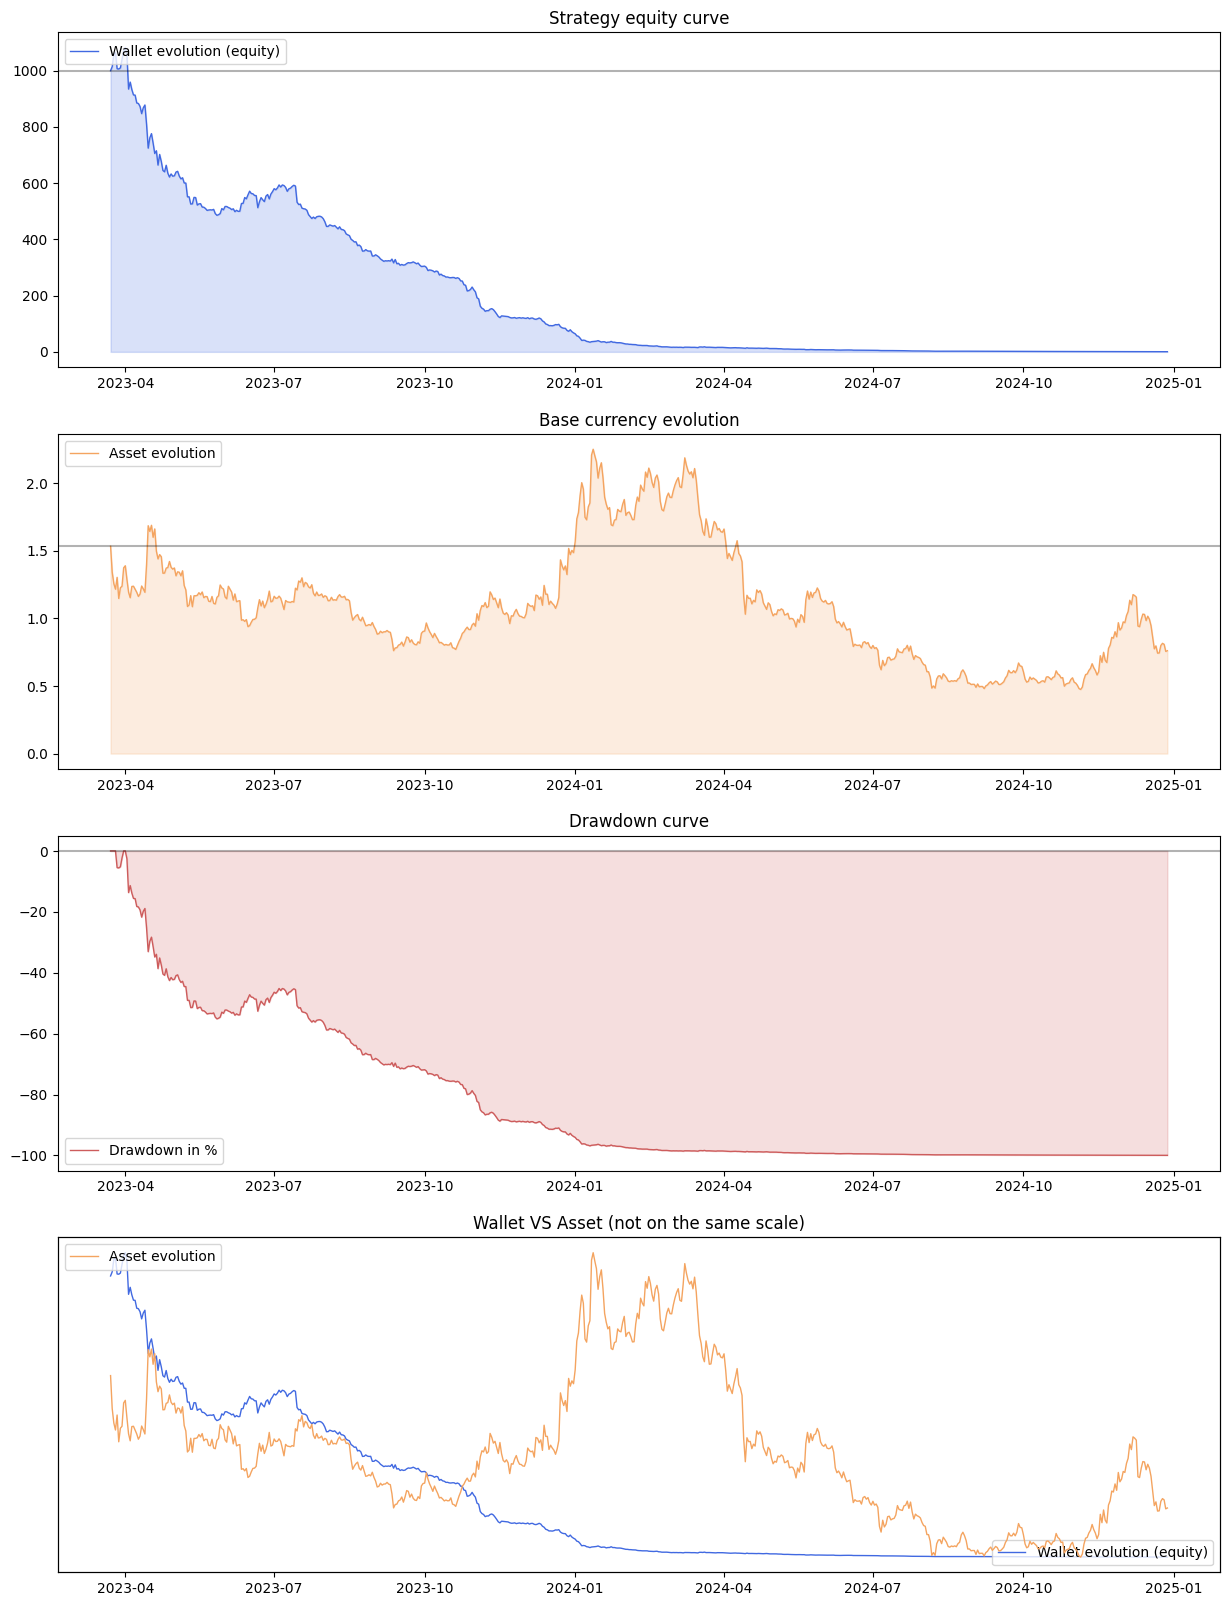

In [24]:
plot_wallet_vs_asset(df_days=df_days)

In [25]:
# plot_futur_simulations(
#     df_trades=df_trades,
#     trades_multiplier=1,
#     trades_to_forecast=1000,
#     number_of_simulations=100,
#     true_trades_to_show=10,
#     show_all_simulations=True,
# )

----- 2023 Cumulative Performances: -93.25% -----


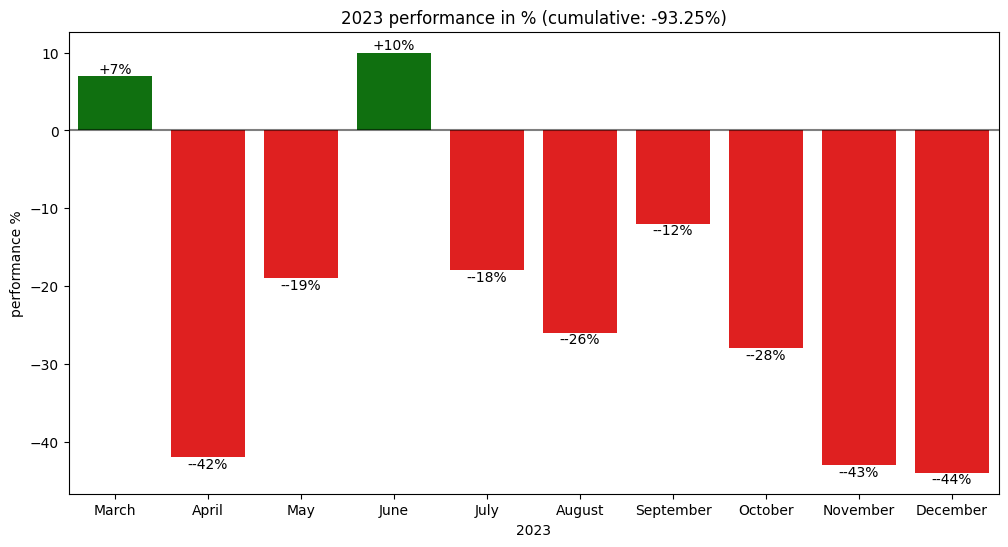

----- 2024 Cumulative Performances: -99.27% -----


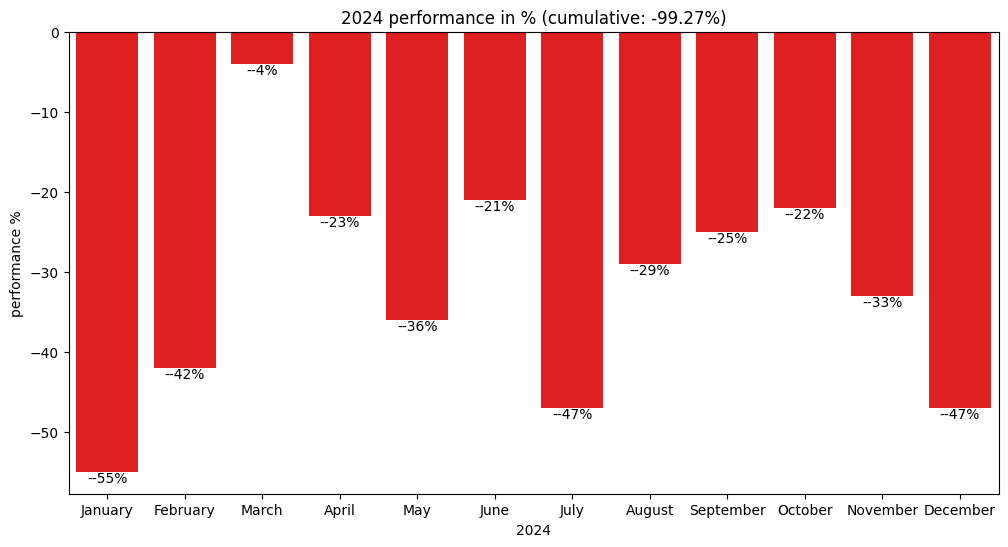

In [26]:
plot_bar_by_month(df_days=df_days)